## Imports

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,
                                     Add, Activation, GlobalAveragePooling1D, LayerNormalization,
                                     MultiHeadAttention, Dropout as KDropout,
                                     GRU, Bidirectional)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## Data Preparation : Load and Combine Data

In [4]:
DATA_PATH = 'G:/Capstone data/karsl-502'
LABELS_PATH = 'G:/Capstone data/KARSL-502_Labels.xlsx'
F_AVG = 30
NUM_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 12

In [5]:
# Load labels
df_labels = pd.read_excel(LABELS_PATH)
w2id = dict(zip(df_labels['Sign-Arabic'], df_labels['SignID']))
words = list(w2id.keys())
label_map = {word: idx for idx, word in enumerate(words)}
NUM_CLASSES = len(words)

In [ ]:
def preprocess_data(data_path, signers, split, f_avg):
    sequences = []
    labels = []
    for word in tqdm(words, desc=f'Loading {split} data for signers {signers}'):
        for signer in signers:
            word_id = w2id[word]
            keypoints_dir = os.path.join(data_path, signer, split, str(word_id).zfill(4))

            required_dirs = ['lh_keypoints', 'rh_keypoints', 'pose_keypoints']
            if not all(os.path.exists(os.path.join(keypoints_dir, d)) for d in required_dirs):
                continue

            lh_dir = os.path.join(keypoints_dir, 'lh_keypoints')
            for sequence in os.listdir(lh_dir):
                try:
                    lh = np.load(os.path.join(lh_dir, sequence))
                    rh = np.load(os.path.join(keypoints_dir, 'rh_keypoints', sequence))
                    pose = np.load(os.path.join(keypoints_dir, 'pose_keypoints', sequence))

                    def pad_sequence(seq):
                        if len(seq) < f_avg:
                            pad = np.tile(seq[-1], (f_avg - len(seq), 1))
                            return np.concatenate([seq, pad])
                        return seq[:f_avg]

                    lh = pad_sequence(lh)
                    rh = pad_sequence(rh)
                    pose = pad_sequence(pose)

                    # Combine pose, lh, rh on last axis (features)
                    combined = np.concatenate([pose, lh, rh], axis=-1)  # shape (f_avg, features)
                    sequences.append(combined)
                    labels.append(label_map[word])
                except Exception as e:
                    print(f"Error loading {sequence}: {e}")

    X = np.array(sequences)
    y = to_categorical(labels, num_classes=NUM_CLASSES)

    return X, y

In [7]:
# Load train and test data
X_train, y_train = preprocess_data(DATA_PATH, ['01', '02','03'], 'train', F_AVG)
X_test, y_test = preprocess_data(DATA_PATH, ['01', '02','03'], 'test', F_AVG)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Loading train data for signers ['01', '02', '03']: 100%|█████████████████████████████| 502/502 [22:56<00:00,  2.74s/it]
Loading test data for signers ['01', '02', '03']: 100%|██████████████████████████████| 502/502 [04:24<00:00,  1.90it/s]


Shapes:
X_train: (58529, 30, 225) y_train: (58529, 502)
X_test: (11110, 30, 225) y_test: (11110, 502)


## Models

### CNN model

In [10]:
def build_cnn_model(input_shape, num_classes):
    """
    CNN model for sequence classification:
    - One Conv1D layer with BatchNorm and ReLU.
    - MaxPooling and Flatten.
    - Dense layer with dropout before classification.
    """
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='CNN')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### ViT model

In [12]:
# (Patch embedding + transformer encoder)

In [13]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = KDropout(rate)
        
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.dropout2 = KDropout(rate)
        
    def call(self, inputs, training=False):
        # PreNorm style
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, x_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        out_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = Dense(embed_dim)
        self.position_embedding = self.add_weight(name="pos_embed", shape=(1, num_patches, embed_dim))
    def call(self, patch):
        x = self.projection(patch)
        return x + self.position_embedding

In [14]:

def build_vit_model(input_shape, num_classes, embed_dim=32, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    """
     ViT model for sequence classification:
    - Patch embedding with smaller embedding size.
    - Single Transformer block stating with few number of heads.
    - Global average pooling and dropout before classification.
    """
    inputs = Input(shape=input_shape)
    x = PatchEmbedding(input_shape[0], embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x)
    x = GlobalAveragePooling1D()(x)
    x = KDropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='ViT')
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### GRU model

In [16]:
def build_gru_model(input_shape, num_classes):
    """
    2-layer GRU model for sequence classification:
    - Two GRU layers with dropout.
    - Dense softmax output layer.
    """
    inputs = Input(shape=input_shape)
    x = GRU(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(64)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='GRU')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Training and evaluation

In [18]:
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, NUM_FOLDS=5, EPOCHS=10, BATCH_SIZE=32):
    builders = {
        'CNN': build_cnn_model,
        'ViT': build_vit_model,
        'GRU': build_gru_model  # Replaced BiT with GRU here
    }
    build_fn = builders[model_name]

    input_shape = X_train.shape[1:]
    y_int = np.argmax(y_train, axis=1)

    results = {k: [] for k in ['train_acc', 'val_acc', 'test_acc', 'train_loss', 'val_loss', 'test_loss']}
    best_test_acc = 0
    best_model_path = None

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_num = 1

    for train_idx, val_idx in skf.split(X_train, y_int):
        print(f"\nTraining fold {fold_num} / {NUM_FOLDS} for {model_name}")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # ** No data augmentation here anymore **
        # Just use original training data:
        # X_tr_aug = X_tr  # you can omit this variable entirely and just pass X_tr below

        model = build_fn(input_shape, y_train.shape[1])
        if fold_num == 1:
            model.summary()

        checkpoint_path = f"{model_name}_fold{fold_num}.h5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

        history = model.fit(
            X_tr, y_tr,  # Pass original data, no augmentation
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[checkpoint, early_stop],
            verbose=2
        )

        train_loss, train_acc = model.evaluate(X_tr, y_tr, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        print(f"Fold {fold_num} results: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        results['test_acc'].append(test_acc)
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['test_loss'].append(test_loss)

        if val_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_path = checkpoint_path

        fold_num += 1

    print(f"\nBest Test accuracy: {best_test_acc:.4f} from model: {best_model_path}")

    return results, best_model_path

### Train CNN

In [19]:
cnn_results, cnn_best_model = train_and_evaluate_model('CNN', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for CNN


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 30, 32)              │          21,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          61,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 502)                 │          64,758 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,086 (578.46 KB)

 Trainable params: 148,022 (578.21 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.61140, saving model to CNN_fold1.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4857 - loss: 2.2267 - val_accuracy: 0.6114 - val_loss: 1.4491
Epoch 2/12

Epoch 2: val_accuracy improved from 0.61140 to 0.80617, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.7978 - loss: 0.6873 - val_accuracy: 0.8062 - val_loss: 0.6558
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.80617
1464/1464 - 5s - 3ms/step - accuracy: 0.8538 - loss: 0.4796 - val_accuracy: 0.7754 - val_loss: 0.7977
Epoch 4/12

Epoch 4: val_accuracy improved from 0.80617 to 0.81360, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8811 - loss: 0.3836 - val_accuracy: 0.8136 - val_loss: 0.6752
Epoch 5/12

Epoch 5: val_accuracy improved from 0.81360 to 0.82385, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8956 - loss: 0.3412 - val_accuracy: 0.8239 - val_loss: 0.6375
Epoch 6/12

Epoch 6: val_accuracy improved from 0.82385 to 0.87929, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9066 - loss: 0.3064 - val_accuracy: 0.8793 - val_loss: 0.4313
Epoch 7/12

Epoch 7: val_accuracy improved from 0.87929 to 0.92628, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9134 - loss: 0.2810 - val_accuracy: 0.9263 - val_loss: 0.2456
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.92628
1464/1464 - 5s - 3ms/step - accuracy: 0.9172 - loss: 0.2683 - val_accuracy: 0.8983 - val_loss: 0.3560
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.92628
1464/1464 - 5s - 3ms/step - accuracy: 0.9262 - loss: 0.2351 - val_accuracy: 0.7324 - val_loss: 1.3222
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.92628
1464/1464 - 5s - 3ms/step - accuracy: 0.9278 - loss: 0.2322 - val_accuracy: 0.8926 - val_loss: 0.3839
Fold 1 results: train_acc=0.9434, val_acc=0.9263, test_acc=0.9303

Training fold 2 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.67777, saving model to CNN_fold2.h5


1464/1464 - 6s - 4ms/step - accuracy: 0.4892 - loss: 2.2325 - val_accuracy: 0.6778 - val_loss: 1.1278
Epoch 2/12

Epoch 2: val_accuracy improved from 0.67777 to 0.73757, saving model to CNN_fold2.h5


1464/1464 - 4s - 3ms/step - accuracy: 0.7964 - loss: 0.6883 - val_accuracy: 0.7376 - val_loss: 0.9089
Epoch 3/12

Epoch 3: val_accuracy improved from 0.73757 to 0.80514, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8527 - loss: 0.4866 - val_accuracy: 0.8051 - val_loss: 0.6703
Epoch 4/12

Epoch 4: val_accuracy improved from 0.80514 to 0.85264, saving model to CNN_fold2.h5


1464/1464 - 4s - 3ms/step - accuracy: 0.8785 - loss: 0.3984 - val_accuracy: 0.8526 - val_loss: 0.4989
Epoch 5/12

Epoch 5: val_accuracy improved from 0.85264 to 0.88784, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8948 - loss: 0.3457 - val_accuracy: 0.8878 - val_loss: 0.3779
Epoch 6/12

Epoch 6: val_accuracy improved from 0.88784 to 0.90663, saving model to CNN_fold2.h5


1464/1464 - 4s - 3ms/step - accuracy: 0.9021 - loss: 0.3110 - val_accuracy: 0.9066 - val_loss: 0.2961
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.90663
1464/1464 - 5s - 3ms/step - accuracy: 0.9110 - loss: 0.2856 - val_accuracy: 0.8736 - val_loss: 0.4174
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.90663
1464/1464 - 4s - 3ms/step - accuracy: 0.9171 - loss: 0.2688 - val_accuracy: 0.8301 - val_loss: 0.6303
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.90663
1464/1464 - 5s - 3ms/step - accuracy: 0.9206 - loss: 0.2517 - val_accuracy: 0.8285 - val_loss: 0.6460
Fold 2 results: train_acc=0.9260, val_acc=0.9066, test_acc=0.9077

Training fold 3 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.64941, saving model to CNN_fold3.h5


1464/1464 - 6s - 4ms/step - accuracy: 0.4839 - loss: 2.2166 - val_accuracy: 0.6494 - val_loss: 1.2667
Epoch 2/12

Epoch 2: val_accuracy improved from 0.64941 to 0.77499, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.7967 - loss: 0.6838 - val_accuracy: 0.7750 - val_loss: 0.7593
Epoch 3/12

Epoch 3: val_accuracy improved from 0.77499 to 0.78404, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8540 - loss: 0.4716 - val_accuracy: 0.7840 - val_loss: 0.7971
Epoch 4/12

Epoch 4: val_accuracy improved from 0.78404 to 0.89083, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8821 - loss: 0.3851 - val_accuracy: 0.8908 - val_loss: 0.3665
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.89083
1464/1464 - 5s - 3ms/step - accuracy: 0.8955 - loss: 0.3367 - val_accuracy: 0.6598 - val_loss: 1.4505
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.89083
1464/1464 - 5s - 3ms/step - accuracy: 0.9031 - loss: 0.3102 - val_accuracy: 0.8696 - val_loss: 0.4624
Epoch 7/12

Epoch 7: val_accuracy improved from 0.89083 to 0.90142, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9132 - loss: 0.2782 - val_accuracy: 0.9014 - val_loss: 0.3449
Epoch 8/12

Epoch 8: val_accuracy improved from 0.90142 to 0.91184, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9197 - loss: 0.2586 - val_accuracy: 0.9118 - val_loss: 0.3008
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.91184
1464/1464 - 5s - 3ms/step - accuracy: 0.9251 - loss: 0.2403 - val_accuracy: 0.8880 - val_loss: 0.3979
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.91184
1464/1464 - 5s - 3ms/step - accuracy: 0.9298 - loss: 0.2266 - val_accuracy: 0.7654 - val_loss: 0.9203
Epoch 11/12

Epoch 11: val_accuracy improved from 0.91184 to 0.91500, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9336 - loss: 0.2140 - val_accuracy: 0.9150 - val_loss: 0.3327
Epoch 12/12

Epoch 12: val_accuracy improved from 0.91500 to 0.91560, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9343 - loss: 0.2022 - val_accuracy: 0.9156 - val_loss: 0.2954
Fold 3 results: train_acc=0.9327, val_acc=0.9156, test_acc=0.9133

Training fold 4 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.66709, saving model to CNN_fold4.h5


1464/1464 - 6s - 4ms/step - accuracy: 0.4836 - loss: 2.2318 - val_accuracy: 0.6671 - val_loss: 1.1466
Epoch 2/12

Epoch 2: val_accuracy improved from 0.66709 to 0.84717, saving model to CNN_fold4.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8008 - loss: 0.6707 - val_accuracy: 0.8472 - val_loss: 0.5165
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.84717
1464/1464 - 5s - 3ms/step - accuracy: 0.8580 - loss: 0.4674 - val_accuracy: 0.7365 - val_loss: 0.9845
Epoch 4/12

Epoch 4: val_accuracy did not improve from 0.84717
1464/1464 - 5s - 3ms/step - accuracy: 0.8822 - loss: 0.3828 - val_accuracy: 0.7336 - val_loss: 1.0568
Epoch 5/12

Epoch 5: val_accuracy improved from 0.84717 to 0.90825, saving model to CNN_fold4.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8971 - loss: 0.3332 - val_accuracy: 0.9083 - val_loss: 0.3027
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.90825
1464/1464 - 5s - 3ms/step - accuracy: 0.9059 - loss: 0.3068 - val_accuracy: 0.8745 - val_loss: 0.4199
Epoch 7/12

Epoch 7: val_accuracy improved from 0.90825 to 0.91355, saving model to CNN_fold4.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9129 - loss: 0.2821 - val_accuracy: 0.9135 - val_loss: 0.2836
Epoch 8/12

Epoch 8: val_accuracy improved from 0.91355 to 0.91885, saving model to CNN_fold4.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9204 - loss: 0.2533 - val_accuracy: 0.9188 - val_loss: 0.2728
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.91885
1464/1464 - 5s - 3ms/step - accuracy: 0.9232 - loss: 0.2445 - val_accuracy: 0.8314 - val_loss: 0.6707
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.91885
1464/1464 - 5s - 3ms/step - accuracy: 0.9284 - loss: 0.2277 - val_accuracy: 0.8959 - val_loss: 0.3643
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.91885
1464/1464 - 5s - 3ms/step - accuracy: 0.9327 - loss: 0.2169 - val_accuracy: 0.8944 - val_loss: 0.3950
Fold 4 results: train_acc=0.9327, val_acc=0.9188, test_acc=0.9195

Training fold 5 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.73738, saving model to CNN_fold5.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4865 - loss: 2.2166 - val_accuracy: 0.7374 - val_loss: 0.9306
Epoch 2/12

Epoch 2: val_accuracy did not improve from 0.73738
1464/1464 - 5s - 4ms/step - accuracy: 0.8019 - loss: 0.6720 - val_accuracy: 0.6718 - val_loss: 1.2098
Epoch 3/12

Epoch 3: val_accuracy improved from 0.73738 to 0.77710, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8568 - loss: 0.4764 - val_accuracy: 0.7771 - val_loss: 0.8121
Epoch 4/12

Epoch 4: val_accuracy improved from 0.77710 to 0.84870, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8794 - loss: 0.3894 - val_accuracy: 0.8487 - val_loss: 0.5154
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.84870
1464/1464 - 5s - 3ms/step - accuracy: 0.8944 - loss: 0.3392 - val_accuracy: 0.8252 - val_loss: 0.6539
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.84870
1464/1464 - 5s - 3ms/step - accuracy: 0.9037 - loss: 0.3140 - val_accuracy: 0.8242 - val_loss: 0.6137
Epoch 7/12

Epoch 7: val_accuracy improved from 0.84870 to 0.88791, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9141 - loss: 0.2756 - val_accuracy: 0.8879 - val_loss: 0.3972
Epoch 8/12

Epoch 8: val_accuracy improved from 0.88791 to 0.91132, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9192 - loss: 0.2603 - val_accuracy: 0.9113 - val_loss: 0.3069
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.91132
1464/1464 - 5s - 3ms/step - accuracy: 0.9248 - loss: 0.2402 - val_accuracy: 0.8666 - val_loss: 0.4901
Epoch 10/12

Epoch 10: val_accuracy improved from 0.91132 to 0.91320, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9280 - loss: 0.2290 - val_accuracy: 0.9132 - val_loss: 0.3069
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.91320
1464/1464 - 5s - 3ms/step - accuracy: 0.9313 - loss: 0.2186 - val_accuracy: 0.9096 - val_loss: 0.3544
Epoch 12/12

Epoch 12: val_accuracy improved from 0.91320 to 0.92738, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9357 - loss: 0.2051 - val_accuracy: 0.9274 - val_loss: 0.2712
Fold 5 results: train_acc=0.9397, val_acc=0.9274, test_acc=0.9219

Best Test accuracy: 0.9303 from model: CNN_fold1.h5


### Train GRU

In [20]:
gru_results, gru_best_model = train_and_evaluate_model('GRU', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for GRU


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 64)              │          55,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 502)                 │          32,630 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,462 (443.21 KB)

 Trainable params: 113,462 (443.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.29711, saving model to GRU_fold1.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.1092 - loss: 4.4544 - val_accuracy: 0.2971 - val_loss: 3.1741
Epoch 2/12

Epoch 2: val_accuracy improved from 0.29711 to 0.52101, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.3576 - loss: 2.7165 - val_accuracy: 0.5210 - val_loss: 2.0357
Epoch 3/12

Epoch 3: val_accuracy improved from 0.52101 to 0.62831, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.5155 - loss: 1.9396 - val_accuracy: 0.6283 - val_loss: 1.4929
Epoch 4/12

Epoch 4: val_accuracy improved from 0.62831 to 0.72211, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.6010 - loss: 1.5259 - val_accuracy: 0.7221 - val_loss: 1.0950
Epoch 5/12

Epoch 5: val_accuracy improved from 0.72211 to 0.77550, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.6607 - loss: 1.2649 - val_accuracy: 0.7755 - val_loss: 0.8851
Epoch 6/12

Epoch 6: val_accuracy improved from 0.77550 to 0.81420, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.7031 - loss: 1.0808 - val_accuracy: 0.8142 - val_loss: 0.7250
Epoch 7/12

Epoch 7: val_accuracy improved from 0.81420 to 0.82855, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7331 - loss: 0.9590 - val_accuracy: 0.8285 - val_loss: 0.6516
Epoch 8/12

Epoch 8: val_accuracy improved from 0.82855 to 0.83461, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7584 - loss: 0.8529 - val_accuracy: 0.8346 - val_loss: 0.6040
Epoch 9/12

Epoch 9: val_accuracy improved from 0.83461 to 0.85204, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7767 - loss: 0.7725 - val_accuracy: 0.8520 - val_loss: 0.5280
Epoch 10/12

Epoch 10: val_accuracy improved from 0.85204 to 0.86298, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7978 - loss: 0.6986 - val_accuracy: 0.8630 - val_loss: 0.4812
Epoch 11/12

Epoch 11: val_accuracy improved from 0.86298 to 0.87981, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8072 - loss: 0.6606 - val_accuracy: 0.8798 - val_loss: 0.4252
Epoch 12/12

Epoch 12: val_accuracy improved from 0.87981 to 0.89159, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8202 - loss: 0.6136 - val_accuracy: 0.8916 - val_loss: 0.3772
Fold 1 results: train_acc=0.9081, val_acc=0.8916, test_acc=0.8905

Training fold 2 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.25184, saving model to GRU_fold2.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.0806 - loss: 4.6329 - val_accuracy: 0.2518 - val_loss: 3.3722
Epoch 2/12

Epoch 2: val_accuracy improved from 0.25184 to 0.50965, saving model to GRU_fold2.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.3241 - loss: 2.8739 - val_accuracy: 0.5097 - val_loss: 2.1343
Epoch 3/12

Epoch 3: val_accuracy improved from 0.50965 to 0.62088, saving model to GRU_fold2.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.4976 - loss: 2.0209 - val_accuracy: 0.6209 - val_loss: 1.5269
Epoch 4/12

Epoch 4: val_accuracy improved from 0.62088 to 0.70417, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5967 - loss: 1.5558 - val_accuracy: 0.7042 - val_loss: 1.1430
Epoch 5/12

Epoch 5: val_accuracy improved from 0.70417 to 0.74996, saving model to GRU_fold2.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.6573 - loss: 1.2674 - val_accuracy: 0.7500 - val_loss: 0.9161
Epoch 6/12

Epoch 6: val_accuracy improved from 0.74996 to 0.78421, saving model to GRU_fold2.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.7040 - loss: 1.0759 - val_accuracy: 0.7842 - val_loss: 0.7729
Epoch 7/12

Epoch 7: val_accuracy improved from 0.78421 to 0.80771, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7312 - loss: 0.9460 - val_accuracy: 0.8077 - val_loss: 0.6973
Epoch 8/12

Epoch 8: val_accuracy improved from 0.80771 to 0.84102, saving model to GRU_fold2.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.7571 - loss: 0.8429 - val_accuracy: 0.8410 - val_loss: 0.5607
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84102 to 0.86614, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7784 - loss: 0.7591 - val_accuracy: 0.8661 - val_loss: 0.4815
Epoch 10/12

Epoch 10: val_accuracy improved from 0.86614 to 0.88168, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7943 - loss: 0.7075 - val_accuracy: 0.8817 - val_loss: 0.4161
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.88168
1464/1464 - 20s - 14ms/step - accuracy: 0.8069 - loss: 0.6523 - val_accuracy: 0.8777 - val_loss: 0.4169
Epoch 12/12

Epoch 12: val_accuracy improved from 0.88168 to 0.88561, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8226 - loss: 0.5931 - val_accuracy: 0.8856 - val_loss: 0.3842
Fold 2 results: train_acc=0.9021, val_acc=0.8856, test_acc=0.8867

Training fold 3 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.25073, saving model to GRU_fold3.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.0925 - loss: 4.5347 - val_accuracy: 0.2507 - val_loss: 3.3464
Epoch 2/12

Epoch 2: val_accuracy improved from 0.25073 to 0.49829, saving model to GRU_fold3.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.3239 - loss: 2.8346 - val_accuracy: 0.4983 - val_loss: 2.1446
Epoch 3/12

Epoch 3: val_accuracy improved from 0.49829 to 0.63087, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.4960 - loss: 2.0407 - val_accuracy: 0.6309 - val_loss: 1.5107
Epoch 4/12

Epoch 4: val_accuracy improved from 0.63087 to 0.69170, saving model to GRU_fold3.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.5841 - loss: 1.6046 - val_accuracy: 0.6917 - val_loss: 1.1958
Epoch 5/12

Epoch 5: val_accuracy improved from 0.69170 to 0.75252, saving model to GRU_fold3.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.6533 - loss: 1.2966 - val_accuracy: 0.7525 - val_loss: 0.9355
Epoch 6/12

Epoch 6: val_accuracy improved from 0.75252 to 0.80335, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6919 - loss: 1.1157 - val_accuracy: 0.8033 - val_loss: 0.7649
Epoch 7/12

Epoch 7: val_accuracy improved from 0.80335 to 0.80882, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7287 - loss: 0.9702 - val_accuracy: 0.8088 - val_loss: 0.7025
Epoch 8/12

Epoch 8: val_accuracy improved from 0.80882 to 0.84000, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7572 - loss: 0.8605 - val_accuracy: 0.8400 - val_loss: 0.5783
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84000 to 0.85836, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7689 - loss: 0.8061 - val_accuracy: 0.8584 - val_loss: 0.5087
Epoch 10/12

Epoch 10: val_accuracy improved from 0.85836 to 0.87827, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7961 - loss: 0.7030 - val_accuracy: 0.8783 - val_loss: 0.4360
Epoch 11/12

Epoch 11: val_accuracy improved from 0.87827 to 0.88177, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8108 - loss: 0.6531 - val_accuracy: 0.8818 - val_loss: 0.4170
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.88177
1464/1464 - 23s - 15ms/step - accuracy: 0.8121 - loss: 0.6397 - val_accuracy: 0.8567 - val_loss: 0.4839
Fold 3 results: train_acc=0.8997, val_acc=0.8818, test_acc=0.8836

Training fold 4 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.29788, saving model to GRU_fold4.h5


1464/1464 - 26s - 18ms/step - accuracy: 0.0914 - loss: 4.5839 - val_accuracy: 0.2979 - val_loss: 3.3063
Epoch 2/12

Epoch 2: val_accuracy improved from 0.29788 to 0.54323, saving model to GRU_fold4.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.3439 - loss: 2.8131 - val_accuracy: 0.5432 - val_loss: 2.0590
Epoch 3/12

Epoch 3: val_accuracy improved from 0.54323 to 0.65283, saving model to GRU_fold4.h5


1464/1464 - 23s - 15ms/step - accuracy: 0.5092 - loss: 1.9855 - val_accuracy: 0.6528 - val_loss: 1.4654
Epoch 4/12

Epoch 4: val_accuracy improved from 0.65283 to 0.71664, saving model to GRU_fold4.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.5931 - loss: 1.5539 - val_accuracy: 0.7166 - val_loss: 1.1643
Epoch 5/12

Epoch 5: val_accuracy improved from 0.71664 to 0.76662, saving model to GRU_fold4.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.6598 - loss: 1.2816 - val_accuracy: 0.7666 - val_loss: 0.9213
Epoch 6/12

Epoch 6: val_accuracy improved from 0.76662 to 0.79053, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6973 - loss: 1.1035 - val_accuracy: 0.7905 - val_loss: 0.7869
Epoch 7/12

Epoch 7: val_accuracy improved from 0.79053 to 0.81710, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7267 - loss: 0.9827 - val_accuracy: 0.8171 - val_loss: 0.6803
Epoch 8/12

Epoch 8: val_accuracy improved from 0.81710 to 0.83256, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7526 - loss: 0.8671 - val_accuracy: 0.8326 - val_loss: 0.6086
Epoch 9/12

Epoch 9: val_accuracy improved from 0.83256 to 0.85964, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7710 - loss: 0.7983 - val_accuracy: 0.8596 - val_loss: 0.5110
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.85964
1464/1464 - 21s - 14ms/step - accuracy: 0.7823 - loss: 0.7560 - val_accuracy: 0.8448 - val_loss: 0.5671
Epoch 11/12

Epoch 11: val_accuracy improved from 0.85964 to 0.88254, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7924 - loss: 0.7063 - val_accuracy: 0.8825 - val_loss: 0.4257
Epoch 12/12

Epoch 12: val_accuracy improved from 0.88254 to 0.88467, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8026 - loss: 0.6775 - val_accuracy: 0.8847 - val_loss: 0.4053
Fold 4 results: train_acc=0.8988, val_acc=0.8847, test_acc=0.8810

Training fold 5 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.27911, saving model to GRU_fold5.h5


1464/1464 - 24s - 16ms/step - accuracy: 0.0933 - loss: 4.5372 - val_accuracy: 0.2791 - val_loss: 3.2777
Epoch 2/12

Epoch 2: val_accuracy improved from 0.27911 to 0.49902, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.3290 - loss: 2.8251 - val_accuracy: 0.4990 - val_loss: 2.1470
Epoch 3/12

Epoch 3: val_accuracy improved from 0.49902 to 0.61025, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.4864 - loss: 2.0464 - val_accuracy: 0.6103 - val_loss: 1.5636
Epoch 4/12

Epoch 4: val_accuracy improved from 0.61025 to 0.69381, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5778 - loss: 1.6179 - val_accuracy: 0.6938 - val_loss: 1.2207
Epoch 5/12

Epoch 5: val_accuracy improved from 0.69381 to 0.75318, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6435 - loss: 1.3234 - val_accuracy: 0.7532 - val_loss: 0.9519
Epoch 6/12

Epoch 6: val_accuracy improved from 0.75318 to 0.79035, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6898 - loss: 1.1307 - val_accuracy: 0.7903 - val_loss: 0.7961
Epoch 7/12

Epoch 7: val_accuracy improved from 0.79035 to 0.81094, saving model to GRU_fold5.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.7220 - loss: 0.9939 - val_accuracy: 0.8109 - val_loss: 0.7010
Epoch 8/12

Epoch 8: val_accuracy improved from 0.81094 to 0.83785, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7488 - loss: 0.8855 - val_accuracy: 0.8378 - val_loss: 0.5917
Epoch 9/12

Epoch 9: val_accuracy improved from 0.83785 to 0.86288, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7703 - loss: 0.7946 - val_accuracy: 0.8629 - val_loss: 0.5116
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.86288
1464/1464 - 21s - 14ms/step - accuracy: 0.7905 - loss: 0.7261 - val_accuracy: 0.7675 - val_loss: 0.8024
Epoch 11/12

Epoch 11: val_accuracy improved from 0.86288 to 0.87894, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8106 - loss: 0.6569 - val_accuracy: 0.8789 - val_loss: 0.4454
Epoch 12/12

Epoch 12: val_accuracy improved from 0.87894 to 0.88945, saving model to GRU_fold5.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8085 - loss: 0.6525 - val_accuracy: 0.8894 - val_loss: 0.3906
Fold 5 results: train_acc=0.9086, val_acc=0.8894, test_acc=0.8913

Best Test accuracy: 0.8905 from model: GRU_fold1.h5


### Train ViT

In [21]:
vit_results, vit_best_model = train_and_evaluate_model('ViT', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for ViT



Model: "ViT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 30, 32)              │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 30, 32)              │          12,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 502)                 │          16,566 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,494 (146.46 KB)

 Trainable params: 37,494 (146.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03203, saving model to ViT_fold1.h5


1464/1464 - 11s - 7ms/step - accuracy: 0.0110 - loss: 5.8647 - val_accuracy: 0.0320 - val_loss: 5.2246
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03203 to 0.10465, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0479 - loss: 4.8136 - val_accuracy: 0.1046 - val_loss: 4.2623
Epoch 3/12

Epoch 3: val_accuracy improved from 0.10465 to 0.20195, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0996 - loss: 4.0987 - val_accuracy: 0.2019 - val_loss: 3.5884
Epoch 4/12

Epoch 4: val_accuracy improved from 0.20195 to 0.31838, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1668 - loss: 3.5423 - val_accuracy: 0.3184 - val_loss: 3.0258
Epoch 5/12

Epoch 5: val_accuracy improved from 0.31838 to 0.38946, saving model to ViT_fold1.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.2371 - loss: 3.0859 - val_accuracy: 0.3895 - val_loss: 2.5771
Epoch 6/12

Epoch 6: val_accuracy improved from 0.38946 to 0.46019, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3013 - loss: 2.7248 - val_accuracy: 0.4602 - val_loss: 2.2407
Epoch 7/12

Epoch 7: val_accuracy improved from 0.46019 to 0.51059, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3600 - loss: 2.4324 - val_accuracy: 0.5106 - val_loss: 1.9799
Epoch 8/12

Epoch 8: val_accuracy improved from 0.51059 to 0.55630, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4047 - loss: 2.2164 - val_accuracy: 0.5563 - val_loss: 1.7832
Epoch 9/12

Epoch 9: val_accuracy improved from 0.55630 to 0.59158, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4490 - loss: 2.0198 - val_accuracy: 0.5916 - val_loss: 1.6057
Epoch 10/12

Epoch 10: val_accuracy improved from 0.59158 to 0.62686, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4922 - loss: 1.8485 - val_accuracy: 0.6269 - val_loss: 1.4584
Epoch 11/12

Epoch 11: val_accuracy improved from 0.62686 to 0.66052, saving model to ViT_fold1.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.5273 - loss: 1.7003 - val_accuracy: 0.6605 - val_loss: 1.3309
Epoch 12/12

Epoch 12: val_accuracy improved from 0.66052 to 0.67734, saving model to ViT_fold1.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.5617 - loss: 1.5674 - val_accuracy: 0.6773 - val_loss: 1.2335
Fold 1 results: train_acc=0.6879, val_acc=0.6773, test_acc=0.6814

Training fold 2 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03067, saving model to ViT_fold2.h5


1464/1464 - 14s - 9ms/step - accuracy: 0.0086 - loss: 5.8749 - val_accuracy: 0.0307 - val_loss: 5.2608
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03067 to 0.11003, saving model to ViT_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.0478 - loss: 4.7743 - val_accuracy: 0.1100 - val_loss: 4.1882
Epoch 3/12

Epoch 3: val_accuracy improved from 0.11003 to 0.21297, saving model to ViT_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.1080 - loss: 4.0087 - val_accuracy: 0.2130 - val_loss: 3.4957
Epoch 4/12

Epoch 4: val_accuracy improved from 0.21297 to 0.29703, saving model to ViT_fold2.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.1732 - loss: 3.4753 - val_accuracy: 0.2970 - val_loss: 2.9881
Epoch 5/12

Epoch 5: val_accuracy improved from 0.29703 to 0.38117, saving model to ViT_fold2.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.2397 - loss: 3.0603 - val_accuracy: 0.3812 - val_loss: 2.5965
Epoch 6/12

Epoch 6: val_accuracy improved from 0.38117 to 0.44883, saving model to ViT_fold2.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.2980 - loss: 2.7374 - val_accuracy: 0.4488 - val_loss: 2.2831
Epoch 7/12

Epoch 7: val_accuracy improved from 0.44883 to 0.49556, saving model to ViT_fold2.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.3472 - loss: 2.4894 - val_accuracy: 0.4956 - val_loss: 2.0692
Epoch 8/12

Epoch 8: val_accuracy improved from 0.49556 to 0.53058, saving model to ViT_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.3907 - loss: 2.2805 - val_accuracy: 0.5306 - val_loss: 1.8785
Epoch 9/12

Epoch 9: val_accuracy improved from 0.53058 to 0.56099, saving model to ViT_fold2.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.4271 - loss: 2.1063 - val_accuracy: 0.5610 - val_loss: 1.7301
Epoch 10/12

Epoch 10: val_accuracy improved from 0.56099 to 0.59226, saving model to ViT_fold2.h5


1464/1464 - 11s - 7ms/step - accuracy: 0.4642 - loss: 1.9519 - val_accuracy: 0.5923 - val_loss: 1.5901
Epoch 11/12

Epoch 11: val_accuracy improved from 0.59226 to 0.62498, saving model to ViT_fold2.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.4960 - loss: 1.8155 - val_accuracy: 0.6250 - val_loss: 1.4694
Epoch 12/12

Epoch 12: val_accuracy improved from 0.62498 to 0.65240, saving model to ViT_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.5291 - loss: 1.6835 - val_accuracy: 0.6524 - val_loss: 1.3555
Fold 2 results: train_acc=0.6731, val_acc=0.6524, test_acc=0.6637

Training fold 3 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.02862, saving model to ViT_fold3.h5


1464/1464 - 11s - 8ms/step - accuracy: 0.0092 - loss: 5.8492 - val_accuracy: 0.0286 - val_loss: 5.2002
Epoch 2/12

Epoch 2: val_accuracy improved from 0.02862 to 0.09192, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0407 - loss: 4.8593 - val_accuracy: 0.0919 - val_loss: 4.3627
Epoch 3/12

Epoch 3: val_accuracy improved from 0.09192 to 0.18802, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0917 - loss: 4.2039 - val_accuracy: 0.1880 - val_loss: 3.6968
Epoch 4/12

Epoch 4: val_accuracy improved from 0.18802 to 0.28942, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1623 - loss: 3.6178 - val_accuracy: 0.2894 - val_loss: 3.0765
Epoch 5/12

Epoch 5: val_accuracy improved from 0.28942 to 0.39006, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2404 - loss: 3.1015 - val_accuracy: 0.3901 - val_loss: 2.5852
Epoch 6/12

Epoch 6: val_accuracy improved from 0.39006 to 0.45105, saving model to ViT_fold3.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.3051 - loss: 2.7159 - val_accuracy: 0.4511 - val_loss: 2.2405
Epoch 7/12

Epoch 7: val_accuracy improved from 0.45105 to 0.50589, saving model to ViT_fold3.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.3623 - loss: 2.4275 - val_accuracy: 0.5059 - val_loss: 1.9800
Epoch 8/12

Epoch 8: val_accuracy improved from 0.50589 to 0.56296, saving model to ViT_fold3.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.4093 - loss: 2.1997 - val_accuracy: 0.5630 - val_loss: 1.7694
Epoch 9/12

Epoch 9: val_accuracy improved from 0.56296 to 0.59790, saving model to ViT_fold3.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.4521 - loss: 2.0061 - val_accuracy: 0.5979 - val_loss: 1.5972
Epoch 10/12

Epoch 10: val_accuracy improved from 0.59790 to 0.63284, saving model to ViT_fold3.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.4939 - loss: 1.8384 - val_accuracy: 0.6328 - val_loss: 1.4534
Epoch 11/12

Epoch 11: val_accuracy improved from 0.63284 to 0.65718, saving model to ViT_fold3.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.5319 - loss: 1.6900 - val_accuracy: 0.6572 - val_loss: 1.3319
Epoch 12/12

Epoch 12: val_accuracy improved from 0.65718 to 0.68760, saving model to ViT_fold3.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.5657 - loss: 1.5566 - val_accuracy: 0.6876 - val_loss: 1.2118
Fold 3 results: train_acc=0.7039, val_acc=0.6876, test_acc=0.6917

Training fold 4 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03349, saving model to ViT_fold4.h5


1464/1464 - 14s - 9ms/step - accuracy: 0.0107 - loss: 5.8560 - val_accuracy: 0.0335 - val_loss: 5.2874
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03349 to 0.09551, saving model to ViT_fold4.h5


1464/1464 - 10s - 7ms/step - accuracy: 0.0446 - loss: 4.8303 - val_accuracy: 0.0955 - val_loss: 4.2791
Epoch 3/12

Epoch 3: val_accuracy improved from 0.09551 to 0.17769, saving model to ViT_fold4.h5


1464/1464 - 11s - 7ms/step - accuracy: 0.0872 - loss: 4.1500 - val_accuracy: 0.1777 - val_loss: 3.6869
Epoch 4/12

Epoch 4: val_accuracy improved from 0.17769 to 0.25671, saving model to ViT_fold4.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.1463 - loss: 3.6556 - val_accuracy: 0.2567 - val_loss: 3.1733
Epoch 5/12

Epoch 5: val_accuracy improved from 0.25671 to 0.35127, saving model to ViT_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.2135 - loss: 3.2134 - val_accuracy: 0.3513 - val_loss: 2.7322
Epoch 6/12

Epoch 6: val_accuracy improved from 0.35127 to 0.42072, saving model to ViT_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.2745 - loss: 2.8584 - val_accuracy: 0.4207 - val_loss: 2.3948
Epoch 7/12

Epoch 7: val_accuracy improved from 0.42072 to 0.47138, saving model to ViT_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.3295 - loss: 2.5681 - val_accuracy: 0.4714 - val_loss: 2.1226
Epoch 8/12

Epoch 8: val_accuracy improved from 0.47138 to 0.51726, saving model to ViT_fold4.h5


1464/1464 - 8s - 6ms/step - accuracy: 0.3747 - loss: 2.3451 - val_accuracy: 0.5173 - val_loss: 1.9128
Epoch 9/12

Epoch 9: val_accuracy improved from 0.51726 to 0.55006, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4152 - loss: 2.1467 - val_accuracy: 0.5501 - val_loss: 1.7423
Epoch 10/12

Epoch 10: val_accuracy improved from 0.55006 to 0.58654, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4494 - loss: 1.9918 - val_accuracy: 0.5865 - val_loss: 1.6006
Epoch 11/12

Epoch 11: val_accuracy improved from 0.58654 to 0.62558, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4880 - loss: 1.8467 - val_accuracy: 0.6256 - val_loss: 1.4576
Epoch 12/12

Epoch 12: val_accuracy improved from 0.62558 to 0.64522, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5163 - loss: 1.7169 - val_accuracy: 0.6452 - val_loss: 1.3591
Fold 4 results: train_acc=0.6549, val_acc=0.6452, test_acc=0.6415

Training fold 5 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.02614, saving model to ViT_fold5.h5


1464/1464 - 11s - 7ms/step - accuracy: 0.0099 - loss: 5.8555 - val_accuracy: 0.0261 - val_loss: 5.2416
Epoch 2/12

Epoch 2: val_accuracy improved from 0.02614 to 0.10944, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0482 - loss: 4.7703 - val_accuracy: 0.1094 - val_loss: 4.1615
Epoch 3/12

Epoch 3: val_accuracy improved from 0.10944 to 0.22016, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1139 - loss: 3.9503 - val_accuracy: 0.2202 - val_loss: 3.4314
Epoch 4/12

Epoch 4: val_accuracy improved from 0.22016 to 0.30782, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1776 - loss: 3.4283 - val_accuracy: 0.3078 - val_loss: 2.9588
Epoch 5/12

Epoch 5: val_accuracy improved from 0.30782 to 0.37454, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2300 - loss: 3.0774 - val_accuracy: 0.3745 - val_loss: 2.6355
Epoch 6/12

Epoch 6: val_accuracy improved from 0.37454 to 0.43588, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2770 - loss: 2.7942 - val_accuracy: 0.4359 - val_loss: 2.3720
Epoch 7/12

Epoch 7: val_accuracy improved from 0.43588 to 0.47749, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3278 - loss: 2.5527 - val_accuracy: 0.4775 - val_loss: 2.1409
Epoch 8/12

Epoch 8: val_accuracy improved from 0.47749 to 0.51773, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3729 - loss: 2.3414 - val_accuracy: 0.5177 - val_loss: 1.9406
Epoch 9/12

Epoch 9: val_accuracy improved from 0.51773 to 0.56933, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4216 - loss: 2.1377 - val_accuracy: 0.5693 - val_loss: 1.7503
Epoch 10/12

Epoch 10: val_accuracy improved from 0.56933 to 0.59223, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4571 - loss: 1.9734 - val_accuracy: 0.5922 - val_loss: 1.6131
Epoch 11/12

Epoch 11: val_accuracy improved from 0.59223 to 0.63212, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4987 - loss: 1.8169 - val_accuracy: 0.6321 - val_loss: 1.4533
Epoch 12/12

Epoch 12: val_accuracy improved from 0.63212 to 0.65750, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5303 - loss: 1.6755 - val_accuracy: 0.6575 - val_loss: 1.3391
Fold 5 results: train_acc=0.6750, val_acc=0.6575, test_acc=0.6613

Best Test accuracy: 0.6917 from model: ViT_fold3.h5


## Plotting Results

In [22]:
all_results = {'CNN': cnn_results, 'ViT': vit_results, 'GRU': gru_results}

In [23]:
# Plotting function for results (multiple models)
def plot_results(all_results):
    metrics = ['acc', 'loss']
    sets = ['train', 'val', 'test']
    models_list = list(all_results.keys())
    model_colors = {'ViT': 'green', 'CNN': 'orange', 'BiT': 'blue'}

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    for i, metric in enumerate(metrics):
        for j, set_name in enumerate(sets):
            key = f'{set_name}_{metric}'
            means = []
            stds = []
            colors = []

            for model in models_list:
                means.append(np.mean(all_results[model][key]))
                stds.append(np.std(all_results[model][key]))
                colors.append(model_colors.get(model, 'black'))

            bars = axes[i, j].bar(models_list, means, width=0.3, color=colors)
            title_map = {
                'train_acc': 'Train Accuracy',
                'val_acc': 'Val Accuracy',
                'test_acc': 'Test Accuracy',
                'train_loss': 'Train Loss',
                'val_loss': 'Val Loss',
                'test_loss': 'Test Loss'
            }
            axes[i, j].set_title(title_map[f'{set_name}_{metric}'])
            if metric == 'acc':
                axes[i, j].set_ylim(0, 1.1)
            else:
                max_loss = max(means) + max(stds)
                axes[i, j].set_ylim(0, max_loss * 1.1)

            for k, bar in enumerate(bars):
                height = bar.get_height()
                offset = 0.02 if height > 0.9 else 0.01
                axes[i, j].text(bar.get_x() + bar.get_width() / 2, height + offset, f'{height:.2f}',
                                ha='center', va='bottom', fontsize=10)

    handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors.get(m, 'black')) for m in models_list]
    fig.legend(handles, models_list, loc='upper right', bbox_to_anchor=(1.1, 1), title='Models', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

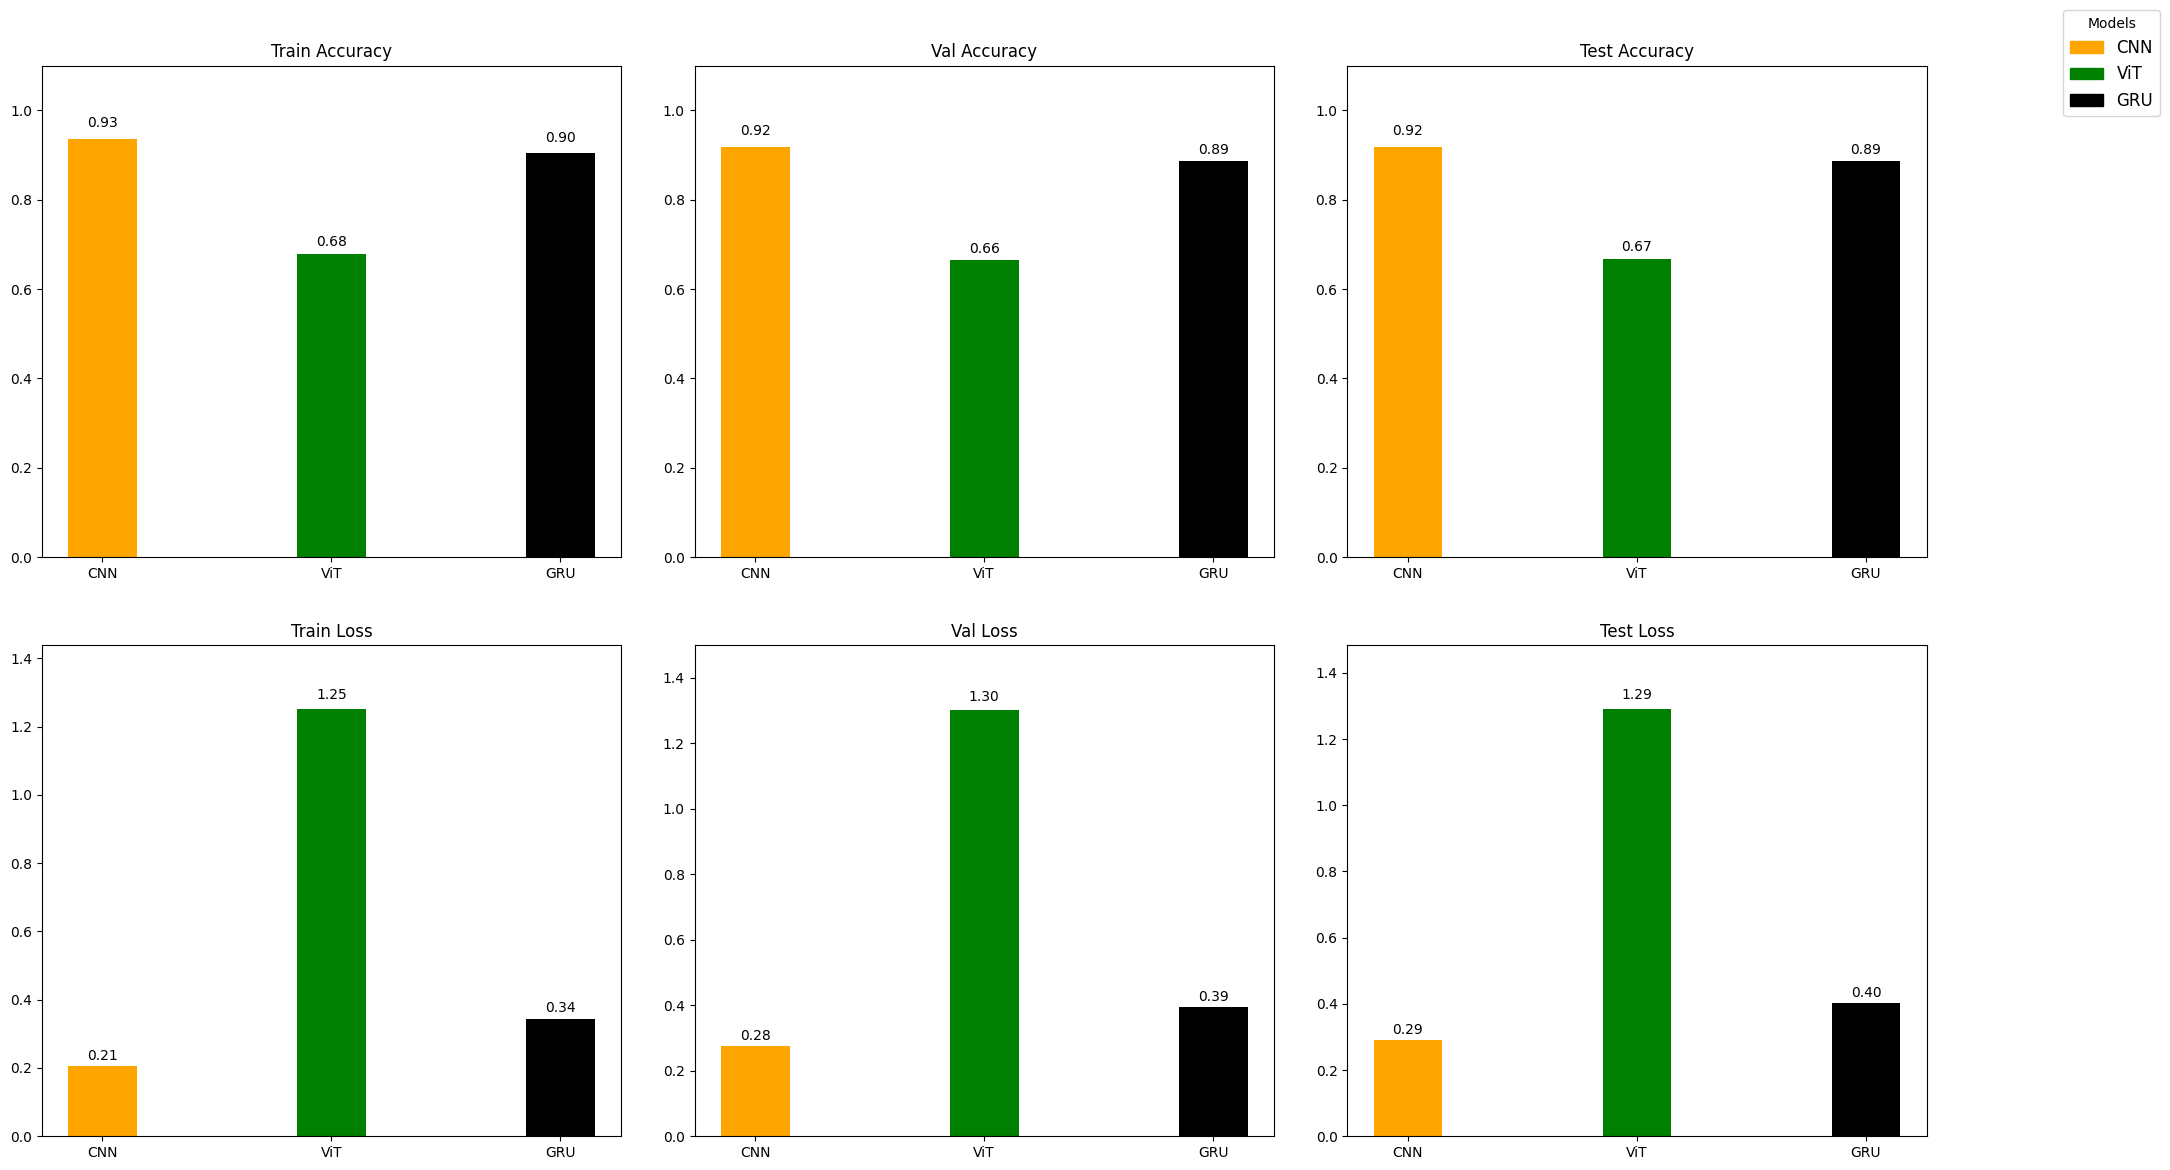

In [24]:
plot_results(all_results)

## Final Average of Results

In [42]:
# Print final average results
def print_final_averages(all_results):
    print("\n" + "="*50)
    print("Final Average Results")
    print("="*50)
    for model in all_results:
        print(f"\n{model} Model:")
        print(f"Train Accuracy: {np.mean(all_results[model]['train_acc']):.4f}")
        print(f"Val Accuracy: {np.mean(all_results[model]['val_acc']):.4f}")
        print(f"Test Accuracy: {np.mean(all_results[model]['test_acc']):.4f}")
        print(f"Train Loss: {np.mean(all_results[model]['train_loss']):.4f}")
        print(f"Val Loss: {np.mean(all_results[model]['val_loss']):.4f}")
        print(f"Test Loss: {np.mean(all_results[model]['test_loss']):.4f}")

In [43]:
print_final_averages(all_results)


Final Average Results

CNN Model:
Train Accuracy: 0.9278
Val Accuracy: 0.9117
Test Accuracy: 0.9119
Train Loss: 0.2318
Val Loss: 0.3085
Test Loss: 0.3178

ViT Model:
Train Accuracy: 0.6794
Val Accuracy: 0.6656
Test Accuracy: 0.6658
Train Loss: 1.2585
Val Loss: 1.3009
Test Loss: 1.2969

GRU Model:
Train Accuracy: 0.9032
Val Accuracy: 0.8864
Test Accuracy: 0.8866
Train Loss: 0.3418
Val Loss: 0.3917
Test Loss: 0.3983
